In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import itertools
import scipy
import copy

import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

import torchvision.transforms as T
import torch.nn.functional as F
import pandas as pd

DATA_PATH = 'E://P6_simplicity_bias//data//color_dsprite3x4.npy'

In [2]:
def edit_dist_list(list_objs):
    tmp = []
    for i in range(len(list_objs)):
        s1, s2 = list_objs[i][0], list_objs[i][1]
        tmp.append(levenshteinDistance(s1, s2))
    return tmp
        
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [3]:
shape_list = ['square', 'ellipse', 'heart']
color_list = ['blue', 'red', 'pink', 'cyan']

data_dsprite = np.load(DATA_PATH)
square_blue = data_dsprite[0]
square_red = data_dsprite[1]
ellipse_blue = data_dsprite[4]
ellipse_red = data_dsprite[5]

data_dsprite_4 = np.zeros((4, 32, 32, 3))
data_dsprite_4[0] = square_blue
data_dsprite_4[1] = ellipse_blue 
data_dsprite_4[2] = square_red
data_dsprite_4[3] = ellipse_red

## Get labels and topsims, in this example, 256 datasets with different labels

In [4]:
def idx_to_labels(idx_list):
    return [LABELS[idx_list[0]], LABELS[idx_list[1]], LABELS[idx_list[2]], LABELS[idx_list[3]]]

def cal_topsim(listA=None, listB=None):
    if listA is None:
        listA = ['bs', 'be', 'rs', 're']
    listA_combi = list(itertools.combinations(listA, 2))
    listA_distance = edit_dist_list(listA_combi)
    
    listB_combi = list(itertools.combinations(listB, 2))
    listB_distance = edit_dist_list(listB_combi)
    rho, p = scipy.stats.spearmanr(listA_distance, listB_distance)
    if np.isnan(rho):
        rho = 0.99
    return rho

def get_map_type(idx_tup, rho):
    if np.unique(idx_tup).shape[0] != len(idx_tup):
        if np.unique(idx_tup).shape[0]==1:
            return 'degenerate'
        else:
            return 'others'
    else:
        # ------- Now all bijections
        if rho == 1:
            return 'compositional'
        else:
            return 'holistic'

In [5]:
# =========== Get code for each mapping

def _get_comp_attributes(listB):
    def _overlap(s1, s2):
        for i in range(len(s1)):
            if s1[i]==s2[i]:
                return s1[i]
    blue = _overlap(listB[0], listB[1])
    red = _overlap(listB[2], listB[3])
    square = _overlap(listB[0], listB[2])
    ellipse = _overlap(listB[1], listB[3]) 
    return blue, red, square, ellipse

def _code_other(listB):
    def _find_idx(listB, tmp):
        idx = []
        for i in range(4):
            if listB[i]==tmp:
                idx.append(i)
        return idx    
    tmp_str='S'
    flag_idx = np.zeros((4,))
    for i in range(4):
        tmp_code = listB[i]
        if listB.count(tmp_code)==1:
            flag_idx[i]=1
            tmp_str += '%s%s.'%(listA[i],listB[i])
        elif flag_idx[i]==0:
            all_idx = _find_idx(listB, tmp_code)
            tmp_tmp_objs = ''
            for j in range(len(all_idx)):
                flag_idx[all_idx[j]] = 1
                tmp_tmp_objs += '%s,'%listA[all_idx[j]]
            tmp_str += '%s%s.'%(tmp_tmp_objs[:-1], listB[i])
        else:
            pass
    return tmp_str[:-1]

def mapping_to_code(listA, listB, map_type):
    if map_type=='holistic':
        code = 'Sbs%s.Sbe%s.Srs%s.Sre%s'%(listB[0], listB[1], listB[2], listB[3])
    elif map_type=='compositional':
        blue, red, square, ellipse = _get_comp_attributes(listB)
        code = 'SAB.Ab%s.Ar%s.Bs%s.Be%s'%(blue, red, square, ellipse)
    elif map_type=='degenerate':
        code = 'Sbs,be,rs,re%s'%listB[0]
    else:
        code = _code_other(listB)
    return code

def cal_mdl_from_code(code):
    mdl = 0
    for s in code:
        p = code.count(s)/len(code)
        mdl += -np.log2(p)
    return mdl

In [6]:
# ------------ Generate labels
LABELS = ['00', '01', '10', '11']
listA=['bs', 'be', 'rs', 're']
data_dict = {}
cnt_comp, cnt_holi, cnt_deg, cnt_other = 0, 0, 0, 0
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                idx = i4 + i3*4 + i2*4*4 + i1*4*4*4
                data_dict[idx] = {}
                label_list = [LABELS[i1], LABELS[i2], LABELS[i3], LABELS[i4]]
                idx_tup = (i1,i2,i3,i4)
                rho = cal_topsim(listA=listA, listB=label_list)
                map_type = get_map_type(idx_tup, rho)
                code = mapping_to_code(listA=listA, listB=label_list, map_type=map_type)
                mdl = cal_mdl_from_code(code)
                
                data_dict[idx]['code'] = code
                data_dict[idx]['mdl'] = mdl
                data_dict[idx]['idx'] = idx
                data_dict[idx]['topsim'] = rho
                data_dict[idx]['type'] = map_type
                data_dict[idx]['labels'] = label_list
                # if map_type == 'compositional':
                #     cnt_comp += 1
                # elif map_type == 'holistic':
                #     cnt_holi += 1
                # elif map_type == 'degenerate':
                #     cnt_deg += 1
                # elif map_type == 'others':
                #     cnt_other += 1     

C:\Users\YIREN\AppData\Local\Temp\ipykernel_24376\1282410995.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = scipy.stats.spearmanr(listA_distance, listB_distance)


In [7]:
data_PD = pd.DataFrame.from_dict(data_dict, orient='index')
data_PD

,code,mdl,idx,topsim,type,labels
0,"Sbs,be,rs,re00",38.548081,0,0.99,degenerate,"[00, 00, 00, 00]"
1,"Sbs,be,rs00.re01",49.245112,1,0.00,others,"[00, 00, 00, 01]"
2,"Sbs,be,rs00.re10",49.245112,2,0.00,others,"[00, 00, 00, 10]"
3,"Sbs,be,rs00.re11",50.000000,3,0.00,others,"[00, 00, 00, 11]"
4,"Sbs,be,re00.rs01",49.245112,4,0.00,others,"[00, 00, 01, 00]"
...,...,...,...,...,...,...
251,"Sbs,be,re11.rs10",49.245112,251,0.00,others,"[11, 11, 10, 11]"
252,"Sbs,be,rs11.re00",50.000000,252,0.00,others,"[11, 11, 11, 00]"
253,"Sbs,be,rs11.re01",49.245112,253,0.00,others,"[11, 11, 11, 01]"
254,"Sbs,be,rs11.re10",49.245112,254,0.00,others,"[11, 11, 11, 10]"


In [8]:
#data_PD.to_csv('data_PD.csv')

In [9]:
listA_combi = list(itertools.combinations(listA, 2))
print(listA_combi)
print(edit_dist_list(listA_combi))

[('bs', 'be'), ('bs', 'rs'), ('bs', 're'), ('be', 'rs'), ('be', 're'), ('rs', 're')]
[1, 1, 2, 2, 1, 1]


In [10]:
listB_combi = list(itertools.combinations(['00', '00', '00', '01'], 2))
print(listB_combi)
print(edit_dist_list(listB_combi))

[('00', '00'), ('00', '00'), ('00', '01'), ('00', '00'), ('00', '01'), ('00', '01')]
[0, 0, 1, 0, 1, 1]


In [11]:
scipy.stats.spearmanr([1,2,3,4,5], [0,0,0,0,0])

C:\Users\YIREN\AppData\Local\Temp\ipykernel_24376\3523242664.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  scipy.stats.spearmanr([1,2,3,4,5], [0,0,0,0,0])


SignificanceResult(statistic=nan, pvalue=nan)

## Create dataset with 4 samples, and then use a CNN to learn that

- The input signal can be one-hot tabular, random dense vector that satisfies the topsim, or image

In [12]:
def get_labels(label_list):
    y1_list, y2_list = [], []
    for i in range(len(label_list)):
        y1_list.append(int(label_list[i][0]))
        y2_list.append(int(label_list[i][1]))
    return torch.tensor(y1_list), torch.tensor(y2_list)

def get_inputs(x_type='img'):
    if x_type=='img':
        return torch.tensor(data_dsprite_4, dtype=torch.float).permute(0,3,1,2)
    elif x_type.startswith('oht'):
        n_class = int(x_type[-1])
        return F.one_hot(torch.tensor([[0,0], [0,1], [1,0], [1,1]]), num_classes=n_class).reshape(4,-1).float()
    elif x_type.startswith('matrix'):
        n_class = int(x_type[-1])
        oht_vector = F.one_hot(torch.tensor([[0,0], [0,1], [1,0], [1,1]]), num_classes=n_class).reshape(4,-1).float()
        return torch.mm(oht_vector, W.float())

In [13]:
class MLP(nn.Module):
  def __init__(self, in_dim=4, hid_size=100, k_clas=2, n_clas=2):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.hid_size = hid_size
    self.k_clas = k_clas
    self.n_clas = n_clas
    self.Alice = nn.Sequential(
              nn.Linear(self.in_dim, self.hid_size),
              nn.ReLU(True),
              nn.Linear(self.hid_size, self.hid_size),
              nn.ReLU(True),
            )
    self.Bob = nn.Sequential(
              nn.Linear(self.hid_size, self.k_clas*self.n_clas)
            )

  def forward(self, x):
    z = self.Alice(x)
    hid = self.Bob(z)
    return z, hid


class MLP_vision(nn.Module):
  def __init__(self, in_dim=32*32*3, hid_size=100, k_clas=2, n_clas=2):
    super(MLP_vision, self).__init__()
    self.in_dim = in_dim
    self.hid_size = hid_size
    self.k_clas = k_clas
    self.n_clas = n_clas
    self.Alice = nn.Sequential(
              nn.Linear(self.in_dim, self.hid_size),
              nn.ReLU(True),
              nn.Linear(self.hid_size, self.hid_size),
              nn.ReLU(True),
            )
    self.Bob = nn.Sequential(
              nn.Linear(self.hid_size, self.k_clas*self.n_clas)
            )

  def forward(self, x):
    z = self.Alice(x.reshape(x.shape[0],-1))
    hid = self.Bob(z)
    return z, hid


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linearA = nn.Linear(128*block.expansion, num_classes)
        self.linearB = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        z = out.view(out.size(0), -1)
        outA = self.linearA(z)
        outB = self.linearB(z)
        return z, torch.cat((outA, outB), -1)

def ResNet8():
    return ResNet(BasicBlock, [1, 1, 1, 1])


# RUN EXPERIMENTS

In [14]:
# -------- Exp_setting
INPUT = 'matrix_oht3' # 'oht2', 'oht3', 'matrix_oht2','matrix_oht3', 'imgres', 'imgmlp'
OPTIM = 'adam' # 'sgd', 'adam', 'adamW', 'RMSProp'
LOSS_TYPE = 'l2' # 'l2' 'ce'

# --- Generate dataset
if INPUT.startswith('oht'):
    in_dim = int(INPUT[-1])*2
    model_seed = MLP(in_dim=in_dim, hid_size=50, k_clas=2, n_clas=2)
    EPOCHS = 200
    LR = 5e-3
    DATA_TYPE = INPUT
elif INPUT.startswith('matrix'):
    in_dim = int(INPUT[-1])*20
    oht_dim = int(INPUT[-1])*2
    W = torch.tensor(np.random.uniform(-1,1,(oht_dim, in_dim)))
    model_seed = MLP(in_dim=in_dim, hid_size=50, k_clas=2, n_clas=2)
    EPOCHS = 200
    LR = 2e-3
    DATA_TYPE = INPUT
elif INPUT == 'imgres':
    model_seed = ResNet8()
    EPOCHS = 50
    LR = 3e-3
    DATA_TYPE = 'img'
elif INPUT == 'imgmlp':
    model_seed = MLP_vision()
    EPOCHS = 50
    LR = 1e-2
    DATA_TYPE = 'img'
    
if OPTIM=='sgd':
    LR = LR
else:
    LR = LR*0.5

EXP_NAME = '%s_%s_%s'%(INPUT, OPTIM, LOSS_TYPE)

In [15]:
train_loss_all = np.zeros((256, EPOCHS))
for j in range(256):
    if j%16==0:
        print(j,end='-')
    ds_idx = j
    x = get_inputs(DATA_TYPE)# img  
    y1, y2 = get_labels(data_PD['labels'][ds_idx])
    x, y1, y2 = x.cuda(), y1.cuda(), y2.cuda()
    
    model = copy.deepcopy(model_seed)
    model.cuda()
    model.train()
    if OPTIM == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0)
    elif OPTIM == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=LR)
    elif OPTIM.lower() == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=LR)
    elif OPTIM.lower() == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=LR)
    
    CE_LOSS = nn.CrossEntropyLoss()
    L2_LOSS = nn.MSELoss()
    
    for i in range(EPOCHS):
        rnd_perm = [0,1,2,3]
        #rnd_perm = [random.choice([0,1,2,3])]
        #random.shuffle(rnd_perm)
        x_, y1_, y2_ = x[rnd_perm,:], y1[rnd_perm], y2[rnd_perm]
        z, hid = model(x_)
        if LOSS_TYPE == 'ce':
            loss = CE_LOSS(hid[:,:2], y1_) + CE_LOSS(hid[:,2:], y2_)
        elif LOSS_TYPE == 'l2':
            loss = L2_LOSS(hid[:,:2], F.one_hot(y1_, 2).float()) + L2_LOSS(hid[:,2:], F.one_hot(y2_, 2).float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        train_loss_all[ds_idx, i]=loss.item()

0-16-32-48-64-80-96-112-128-144-160-176-192-208-224-240-

In [16]:
np.save('results//%s.npy'%EXP_NAME,train_loss_all)

In [17]:
COLOR_LIST = {'compositional':'blue', 'holistic':'red', 'degenerate':'green', 'others':'gray'}
ALPHA_LIST = {'compositional':1, 'holistic':1, 'degenerate':1, 'others':0.2}
MARK_LIST = {'compositional':'x', 'holistic':'+', 'degenerate':'*', 'others':'.'}

results_dict = {'x_mdl':[],'x_topsim':[], 'y':[], 'type':[]}
for idx in range(256):
    mdl = data_PD['mdl'][idx]
    topsim = data_PD['topsim'][idx]
    learning_speed = train_loss_all[idx].sum()
    color = COLOR_LIST[data_PD['type'][idx]]
    alpha = ALPHA_LIST[data_PD['type'][idx]]
    marker= MARK_LIST[data_PD['type'][idx]]
    results_dict['x_mdl'].append(mdl)
    results_dict['x_topsim'].append(topsim)
    results_dict['y'].append(learning_speed)
    results_dict['type'].append(data_PD['type'][idx])
results_dict_pd = pd.DataFrame(results_dict)

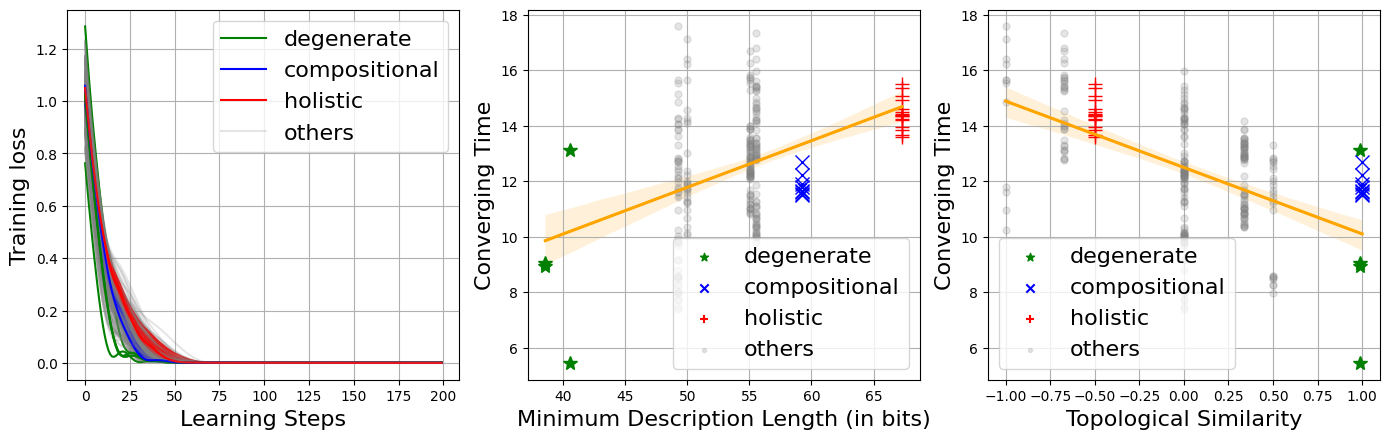

In [18]:
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

for idx in range(256):
    color = COLOR_LIST[data_PD['type'][idx]]
    alpha = ALPHA_LIST[data_PD['type'][idx]]
    ax[0].plot(train_loss_all[idx], color = color,alpha=alpha)
    
ax[0].plot(train_loss_all[0], color = 'green',alpha=1,label='degenerate')
ax[0].plot(train_loss_all[27], color = 'blue',alpha=1,label='compositional')
ax[0].plot(train_loss_all[30], color = 'red',alpha=1,label='holistic')
ax[0].plot(train_loss_all[1], color = 'gray',alpha=0.2,label='others')
ax[0].legend(fontsize=16)
ax[0].set_xlabel('Learning Steps',fontsize=16)
ax[0].set_ylabel('Training loss', fontsize=16)
ax[0].grid()
#ax[0].set_yscale('log')

# ================ MDL

for idx in range(256):
    mdl = data_PD['mdl'][idx]
    learning_speed = train_loss_all[idx].sum()
    color = COLOR_LIST[data_PD['type'][idx]]
    alpha = ALPHA_LIST[data_PD['type'][idx]]
    marker= MARK_LIST[data_PD['type'][idx]]
    ax[1].plot(mdl, learning_speed, color=color, marker=marker,markersize=10, alpha=alpha)

x_bins = np.arange(35, 70, 0.01)
sns.regplot(data=results_dict_pd,x='x_mdl',y='y', x_bins=x_bins, fit_reg=True, ax=ax[1], scatter=False, line_kws=dict(color="orange"))

ax[1].scatter(data_PD['mdl'][0], train_loss_all[0].sum(), color = 'green', marker='*', alpha=1,label='degenerate')
ax[1].scatter(data_PD['mdl'][27], train_loss_all[27].sum(), color = 'blue',marker='x', alpha=1,label='compositional')
ax[1].scatter(data_PD['mdl'][30], train_loss_all[30].sum(), color = 'red',marker='+', alpha=1,label='holistic')
ax[1].scatter(data_PD['mdl'][1], train_loss_all[1].sum(), color = 'gray',marker='.', alpha=0.2,label='others')
ax[1].legend(fontsize=16)
ax[1].set_xlabel('Minimum Description Length (in bits)',fontsize=16)
ax[1].set_ylabel('Converging Time', fontsize=16)
ax[1].grid()

# ================ Topsim

for idx in range(256):
    topsim = data_PD['topsim'][idx]
    learning_speed = train_loss_all[idx].sum()
    color = COLOR_LIST[data_PD['type'][idx]]
    alpha = ALPHA_LIST[data_PD['type'][idx]]
    marker= MARK_LIST[data_PD['type'][idx]]
    ax[2].plot(topsim, learning_speed, color=color, marker=marker,markersize=10, alpha=alpha)

x_bins = np.arange(-1.1, 1.1, 0.01)
sns.regplot(data=results_dict_pd,x='x_topsim',y='y', x_bins=x_bins, fit_reg=True, ax=ax[2], scatter=False, line_kws=dict(color="orange"))

ax[2].scatter(data_PD['topsim'][0], train_loss_all[0].sum(), color = 'green', marker='*', alpha=1,label='degenerate')
ax[2].scatter(data_PD['topsim'][27], train_loss_all[27].sum(), color = 'blue',marker='x', alpha=1,label='compositional')
ax[2].scatter(data_PD['topsim'][30], train_loss_all[30].sum(), color = 'red',marker='+', alpha=1,label='holistic')
ax[2].scatter(data_PD['topsim'][1], train_loss_all[1].sum(), color = 'gray',marker='.', alpha=0.2,label='others')
ax[2].legend(fontsize=16)
ax[2].set_xlabel('Topological Similarity',fontsize=16)
ax[2].set_ylabel('Converging Time', fontsize=16)
ax[2].grid()

plt.tight_layout()
#plt.savefig('E://P6_simplicity_bias//figures//%s.pdf'%EXP_NAME)

In [19]:
print(EXP_NAME)
print(scipy.stats.pearsonr(results_dict_pd['x_mdl'], results_dict_pd['y']))
print(scipy.stats.pearsonr(results_dict_pd['x_topsim'], results_dict_pd['y']))

matrix_oht3_adam_l2
PearsonRResult(statistic=0.3795466621251741, pvalue=3.3951164226574915e-10)
PearsonRResult(statistic=-0.526597168776791, pvalue=1.149809480734217e-19)


In [20]:
# fig, ax = plt.subplots(1,2,figsize=(11,5))

# for idx in range(256):
#     color = COLOR_LIST[data_PD['type'][idx]]
#     alpha = ALPHA_LIST[data_PD['type'][idx]]
#     ax[0].plot(train_loss_all[idx], color = color,alpha=alpha)
    
# ax[0].plot(train_loss_all[0], color = 'green',alpha=1,label='degenerate')
# ax[0].plot(train_loss_all[27], color = 'blue',alpha=1,label='compositional')
# ax[0].plot(train_loss_all[30], color = 'red',alpha=1,label='holistic')
# ax[0].plot(train_loss_all[1], color = 'gray',alpha=0.2,label='others')
# ax[0].legend(fontsize=16)
# ax[0].set_xlabel('Learning Steps',fontsize=16)
# ax[0].set_ylabel('Training loss', fontsize=16)
# ax[0].grid()
# #ax[0].set_yscale('log')

# for idx in range(256):
#     mdl = data_PD['mdl'][idx]
#     learning_speed = train_loss_all[idx].sum()
#     color = COLOR_LIST[data_PD['type'][idx]]
#     alpha = ALPHA_LIST[data_PD['type'][idx]]
#     marker= MARK_LIST[data_PD['type'][idx]]
#     ax[1].plot(mdl, learning_speed, color=color, marker=marker,markersize=10, alpha=alpha)

# x_bins = np.arange(35, 70, 0.01)
# sns.regplot(data=results_dict_pd,x='x_mdl',y='y', x_bins=x_bins, fit_reg=True, ax=ax[1], scatter=False, line_kws=dict(color="orange"))

# ax[1].scatter(data_PD['mdl'][0], train_loss_all[0].sum(), color = 'green', marker='*', alpha=1,label='degenerate')
# ax[1].scatter(data_PD['mdl'][27], train_loss_all[27].sum(), color = 'blue',marker='x', alpha=1,label='compositional')
# ax[1].scatter(data_PD['mdl'][30], train_loss_all[30].sum(), color = 'red',marker='+', alpha=1,label='holistic')
# ax[1].scatter(data_PD['mdl'][1], train_loss_all[1].sum(), color = 'gray',marker='.', alpha=0.2,label='others')
# ax[1].legend(fontsize=16)
# ax[1].set_xlabel('Minimum Description Length (in bits)',fontsize=16)
# ax[1].set_ylabel('Converging Time', fontsize=16)
# ax[1].grid()

# plt.tight_layout()
# #plt.savefig('figures//toy256_learning_speed.pdf')